# SBANN
## ~~Just a Fit But Call it a Model Neural Network~~
## Size and Batch Adaptable Neural Network

Import necessary packages

In [9]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import linalg as la
from keras import regularizers
from keras import backend as K
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape

### Data

Define core features of the dataset

In [10]:
dim = 2
numpart = 30
latent_dim = 2
box_size = 10

Import and reshape data

In [3]:
fname = r'\\wsl$\Ubuntu\home\alepitte\ale\uni\variational-autoencoders\mc-sampling\dump\test_30_10_1_0.75_0.2_10000_2500_5_x.txt'

with open(fname) as f:
    data = [
        [float(i.strip()) for i in s.split(" ") if i != ""]
        for s in f.read().split("\n")
        if s != ""]

    
#labels = [row[-1] for row in data]

#for row in data:
#    del row[-1]

In [4]:
print(data[1])

[9.886406, 1.733028, 5.70476, 2.535296, 2.840124, 2.350916, 1.765133, 0.618148, 4.150855, 1.776409, 0.273838, 2.5205, 2.162391, 1.565633, 8.438227, 0.122682, 0.77619, 1.349542, 7.692682, 1.124421, 3.571692, 3.226635, 5.117197, 0.406894, 5.477664, 3.650954, 7.615125, 3.490127, 2.773286, 0.202774, 6.421184, 1.101841, 0.228484, 0.43304, 7.187389, 0.15407, 5.486495, 1.438391, 9.513661, 0.717713, 3.18499, 1.307135, 1.384128, 2.413111, 9.879337, 3.398973, 7.846247, 2.163855, 3.992875, 0.48304, 8.812831, 1.430235, 6.729518, 2.117621, 4.687167, 2.894377, 8.77692, 2.687815, 6.587482, 3.315774]


In [5]:
vcs = np.array(data).reshape((-1,numpart,dim))/(box_size*np.sqrt(2))
#vcs = np.array(data)
print(vcs.shape,vcs[1])

(10000, 30, 2) [[0.69907447 0.12254359]
 [0.40338745 0.1792725 ]
 [0.20082709 0.16623486]
 [0.12481375 0.04370966]
 [0.29350977 0.12561109]
 [0.01936327 0.17822626]
 [0.15290413 0.11070697]
 [0.59667275 0.00867493]
 [0.05488492 0.09542703]
 [0.54395476 0.07950857]
 [0.25255676 0.22815755]
 [0.36184047 0.02877175]
 [0.38732934 0.25816143]
 [0.53847065 0.24678925]
 [0.19610093 0.01433829]
 [0.45404627 0.07791192]
 [0.01615626 0.03062055]
 [0.50822515 0.01089439]
 [0.38795378 0.1017096 ]
 [0.67271742 0.05074997]
 [0.2252128  0.0924284 ]
 [0.09787263 0.17063272]
 [0.69857462 0.24034369]
 [0.55481345 0.15300765]
 [0.2823389  0.03415609]
 [0.62316126 0.10113289]
 [0.47584878 0.14973842]
 [0.33143276 0.20466336]
 [0.62062196 0.19005722]
 [0.46580532 0.23446063]]


In [6]:
sortmode = 1
if sortmode==1:

    # Calculate distances from (0, 0)
    distances = np.sqrt(vcs[:,:,0]**2 + vcs[:,:,1]**2)
    idx = np.argsort(distances, axis=1)
    sorted_vcs = np.empty_like(vcs)
    for i in range(len(vcs)):
        sorted_vcs[i] = vcs[i][idx[i]]

    print(sorted_vcs.shape,"\n",sorted_vcs[1])

(10000, 30, 2) 
 [[0.01615626 0.03062055]
 [0.05488492 0.09542703]
 [0.12481375 0.04370966]
 [0.01936327 0.17822626]
 [0.15290413 0.11070697]
 [0.19610093 0.01433829]
 [0.09787263 0.17063272]
 [0.2252128  0.0924284 ]
 [0.20082709 0.16623486]
 [0.2823389  0.03415609]
 [0.29350977 0.12561109]
 [0.25255676 0.22815755]
 [0.36184047 0.02877175]
 [0.33143276 0.20466336]
 [0.38795378 0.1017096 ]
 [0.40338745 0.1792725 ]
 [0.45404627 0.07791192]
 [0.38732934 0.25816143]
 [0.47584878 0.14973842]
 [0.50822515 0.01089439]
 [0.46580532 0.23446063]
 [0.54395476 0.07950857]
 [0.55481345 0.15300765]
 [0.53847065 0.24678925]
 [0.59667275 0.00867493]
 [0.62316126 0.10113289]
 [0.62062196 0.19005722]
 [0.67271742 0.05074997]
 [0.69907447 0.12254359]
 [0.69857462 0.24034369]]


### Compute distance matrix

In [7]:
dm = np.zeros((len(vcs),numpart,numpart))

for i in range(len(vcs)):
               dm[i]=squareform(pdist(sorted_vcs[i], metric='euclidean'), force='no', checks=True)
               
print(dm.shape, '\n', dm[1])

(10000, 30, 30) 
 [[0.         0.07549695 0.10944302 0.14764055 0.15847339 0.18067982
  0.16211407 0.21800195 0.22911691 0.26620612 0.29316919 0.30806828
  0.34568916 0.36012521 0.37853276 0.41478355 0.44043631 0.43536686
  0.47487502 0.49246413 0.49369531 0.53005782 0.55238589 0.56527978
  0.58093116 0.61108678 0.62513906 0.65686966 0.68907701 0.71391779]
 [0.07549695 0.         0.08697544 0.09009717 0.09920304 0.16284148
  0.0866247  0.17035427 0.16221241 0.23556197 0.24052629 0.23809987
  0.31410927 0.29734035 0.33312811 0.35844675 0.39954545 0.37013751
  0.42445294 0.46115413 0.43380401 0.48932883 0.5032336  0.50672052
  0.54868933 0.56830498 0.57359679 0.61944575 0.64476002 0.65980093]
 [0.10944302 0.08697544 0.         0.17092255 0.07264784 0.07710084
  0.12975086 0.11159518 0.14418895 0.15781458 0.1875265  0.22436421
  0.23749696 0.26191126 0.26945625 0.30980734 0.3310043  0.33897492
  0.36669836 0.38481313 0.3907188  0.42066703 0.44367306 0.46081813
  0.47315785 0.50164496 0.51

Split in training and test set

In [8]:
train_perc=0.8

trainset_conf = sorted_vcs[:int(train_perc*len(dm))]
print(trainset_conf.shape)
testset_conf = sorted_vcs[int(train_perc*len(dm)):]
print(testset_conf.shape)

trainset_mat = dm[:int(train_perc*len(dm))]
print(trainset_mat.shape)
testset_mat = dm[int(train_perc*len(dm)):]
print(testset_mat.shape)

(8000, 30, 2)
(2000, 30, 2)
(8000, 30, 30)
(2000, 30, 30)


### Sampling class

In [9]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
class DistanceMatrixLayer(layers.Layer):
    def __init__(self):
        super(DistanceMatrixLayer, self).__init__()

    def call(self, inputs):
        numpart, dim = inputs.shape[0], inputs.shape[1]

        arrayd = []
        
        for i, data in enumerate(inputs):
            for j, data in enumerate(inputs):
                arrayd[j+i*inputs.shape[0]] = np.linalg.norm(data[i]-data[j])
        
        arrayd = np.array(arrayd)

        return arrayd

In [11]:
class DistanceMatrixLayer(layers.Layer):
    def __init__(self):
        super(DistanceMatrixLayer, self).__init__()

    def call(self, inputs):
        numpart, dim = inputs.shape[1], inputs.shape[2]

        # Compute pairwise distances
        expanded_inputs = tf.expand_dims(inputs, axis=1)
        expanded_inputs_transpose = tf.transpose(expanded_inputs, perm=[0, 2, 1, 3])
        pairwise_distances = tf.norm(expanded_inputs - expanded_inputs_transpose, axis=-1)

        # Normalize distances
        #normalized_distances = pairwise_distances / (numpart * dim)

        return tf.keras.layers.Flatten()(pairwise_distances)

### Encoder

In [12]:
encoder_inputs = keras.Input(shape=(numpart, numpart, 1))
x = Conv2D(32, 3, padding='same', activation='relu')(encoder_inputs)
#x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
x = Flatten()(x) #Flatten


z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 30, 30, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 57600)        0           ['conv2d_1[0][0]']               
                                                                                            

### Decoder

In [13]:
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
#x = Conv2DTranspose(128, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
decoder_outputs = Conv2DTranspose(1, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

decoder = keras.Model(decoder_input, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 57600)             172800    
                                                                 
 reshape (Reshape)           (None, 30, 30, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 30, 30, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 30, 30, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 30, 30, 1)        289 

### VAE Class

In [14]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            size = reconstruction.shape[1:]  # Extract dimensions excluding the first 'None' dimension
            noise = np.random.normal(0, 0.1, size=size)
            reconstruction = reconstruction + noise
            
            # Reshape data to match decoder output shape
            data = tf.expand_dims(data, axis=-1)
            
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + reg_lambda * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Train VAE

In [15]:
reg_lambda=0.001
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001)) #lower learning rate
fit=vae.fit(trainset_mat, epochs=10, batch_size=128, verbose=2)

Epoch 1/10
63/63 - 42s - loss: 0.0230 - reconstruction_loss: 0.0215 - kl_loss: 1.4949 - 42s/epoch - 666ms/step
Epoch 2/10
63/63 - 36s - loss: 0.0062 - reconstruction_loss: 0.0058 - kl_loss: 0.3923 - 36s/epoch - 572ms/step
Epoch 3/10
63/63 - 35s - loss: 0.0049 - reconstruction_loss: 0.0048 - kl_loss: 0.0847 - 35s/epoch - 553ms/step
Epoch 4/10
63/63 - 35s - loss: 0.0047 - reconstruction_loss: 0.0047 - kl_loss: 0.0055 - 35s/epoch - 555ms/step
Epoch 5/10
63/63 - 35s - loss: 0.0047 - reconstruction_loss: 0.0047 - kl_loss: 0.0019 - 35s/epoch - 551ms/step
Epoch 6/10
63/63 - 35s - loss: 0.0047 - reconstruction_loss: 0.0047 - kl_loss: 9.7818e-04 - 35s/epoch - 552ms/step
Epoch 7/10
63/63 - 35s - loss: 0.0047 - reconstruction_loss: 0.0047 - kl_loss: 7.6053e-04 - 35s/epoch - 552ms/step
Epoch 8/10
63/63 - 35s - loss: 0.0047 - reconstruction_loss: 0.0047 - kl_loss: 4.3975e-04 - 35s/epoch - 557ms/step
Epoch 9/10
63/63 - 35s - loss: 0.0046 - reconstruction_loss: 0.0046 - kl_loss: 4.9000e-04 - 35s/epoc

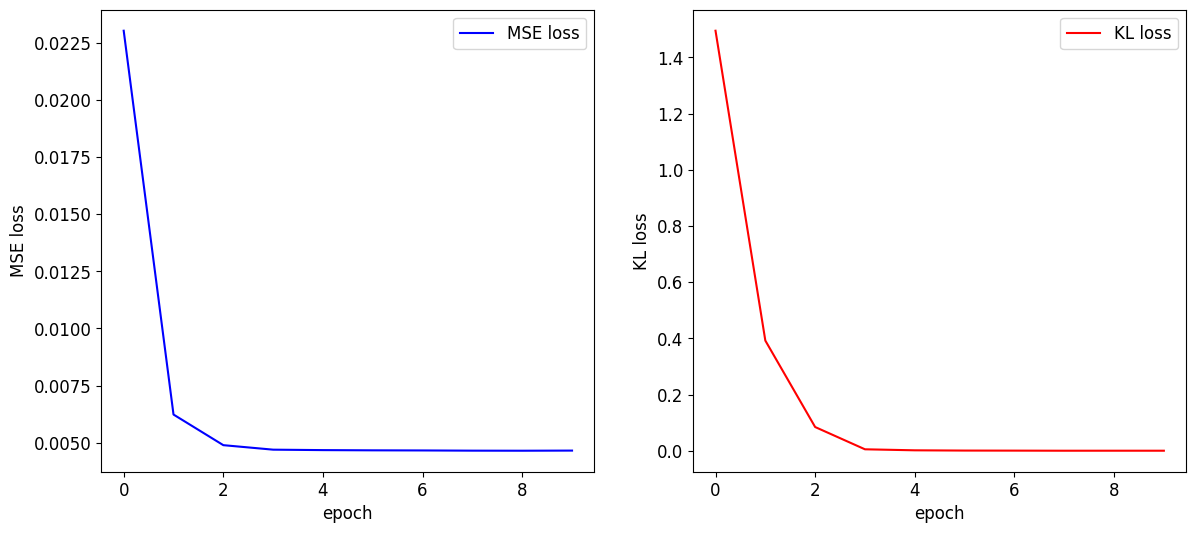

In [16]:
plt.rcParams['font.size'] = 12
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['loss'],label="MSE loss",c="b")
ax.set_xlabel('epoch')
ax.set_ylabel("MSE loss")
ax.legend()
ax=AX[1]
ax.plot(fit.history['kl_loss'],label="KL loss",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("KL loss")
ax.legend()

## Evaluate performance
We'll now use the test set to explore the latent space distribution of data and the reconstruction accuracy

In [17]:
encoded_test = np.array(vae.encoder.predict(testset_mat))

63/63 [==============================] - 1s 11ms/step


In [18]:
print(encoded_test.shape)

(3, 2000, 2)


z_mean are the first dimension, z_log_var the second (used in training), we're interested in the third dimension, which are the sampled z

In [19]:
dim1 = encoded_test[2,:,:]
print(dim1.shape)

(2000, 2)


Sampling in the latent space is reasonably gaussian as expected

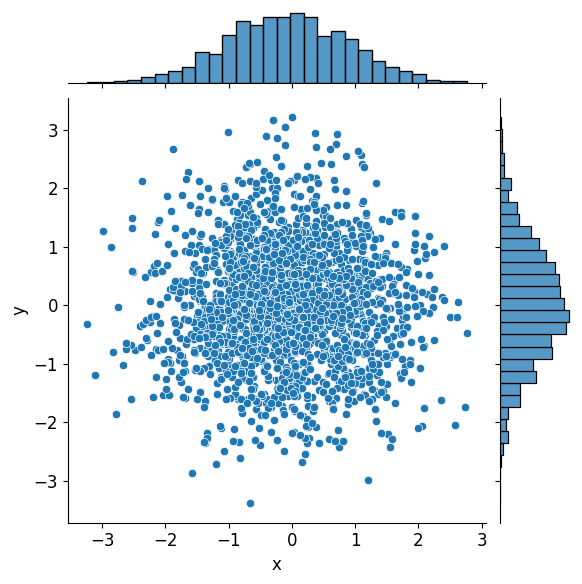

In [20]:
df = pd.DataFrame(dim1, columns=["x", "y"])
sns.jointplot(x="x", y="y", data=df);

We can now use the data to decode

In [21]:
decoded_test = np.array(decoder.predict(encoded_test[2,:,:])).reshape(-1,30,30)
print(decoded_test.shape)

63/63 [==============================] - 3s 43ms/step
(2000, 30, 30)


#### Check reconstruction

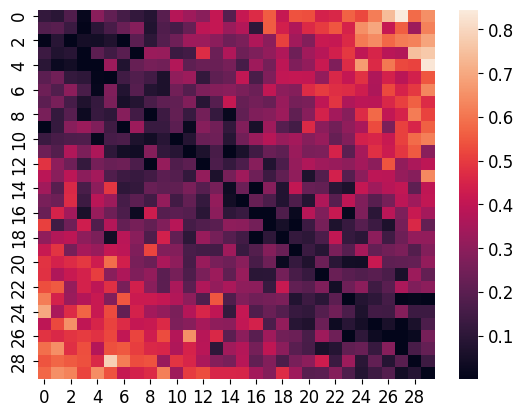

In [22]:
decoded_test[1]
df = pd.DataFrame(decoded_test[1])
sns.heatmap(data=df);

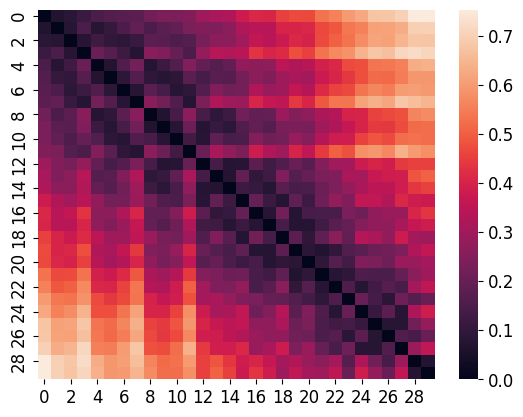

In [23]:
ts = testset_mat.reshape(-1,30,30)
df2 = pd.DataFrame(ts[10])
sns.heatmap(data=df2);

## La segunda parte

In [11]:
class CoordinateReconstructionLayer(layers.Layer):
    def __init__(self, numpart, dim):
        super(CoordinateReconstructionLayer, self).__init__()
        self.numpart = numpart
        self.dim = dim

        # Define the trainable layer(s) for coordinate reconstruction
        self.dense1 = layers.Dense(self.numpart**2, activation='softsign')
        self.dense2 = layers.Dense(self.numpart * self.dim)
 
    def call(self, inputs):
        # Reconstruct coordinates from distance matrix
        x = self.dense1(inputs)
        reconstructed_coordinates = self.dense2(x)

        # Reshape the output to match the coordinate shape
        reconstructed_coordinates = tf.reshape(reconstructed_coordinates, (-1, self.numpart, self.dim))

        return reconstructed_coordinates

In [13]:
rec_inputs = layers.Input(shape=(numpart,numpart))
x = Flatten()(rec_inputs)
x = layers.Dense(int(numpart**2 *4/5), activation='relu')(x)
rec_outputs = CoordinateReconstructionLayer(numpart,dim)(x)
reconstruction = keras.Model(rec_inputs,rec_outputs)
reconstruction.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 30)]          0         
                                                                 
 flatten (Flatten)           (None, 900)               0         
                                                                 
 dense_4 (Dense)             (None, 720)               648720    
                                                                 
 coordinate_reconstruction_l  (None, 30, 2)            702960    
 ayer_1 (CoordinateReconstru                                     
 ctionLayer)                                                     
                                                                 
Total params: 1,351,680
Trainable params: 1,351,680
Non-trainable params: 0
_________________________________________________________________


In [43]:
reconstruction.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.MeanSquaredError()) #lower learning rate
fit=reconstruction.fit(trainset_conf, trainset_conf, epochs=100, batch_size=128, verbose=2)

Epoch 1/100
63/63 - 2s - loss: 0.0142 - 2s/epoch - 35ms/step
Epoch 2/100
63/63 - 1s - loss: 0.0051 - 1s/epoch - 23ms/step
Epoch 3/100
63/63 - 1s - loss: 0.0041 - 1s/epoch - 23ms/step
Epoch 4/100
63/63 - 1s - loss: 0.0034 - 1s/epoch - 23ms/step
Epoch 5/100
63/63 - 1s - loss: 0.0029 - 1s/epoch - 23ms/step
Epoch 6/100
63/63 - 1s - loss: 0.0026 - 1s/epoch - 22ms/step
Epoch 7/100
63/63 - 1s - loss: 0.0024 - 1s/epoch - 22ms/step
Epoch 8/100
63/63 - 1s - loss: 0.0022 - 1s/epoch - 22ms/step
Epoch 9/100
63/63 - 1s - loss: 0.0021 - 1s/epoch - 22ms/step
Epoch 10/100
63/63 - 1s - loss: 0.0019 - 1s/epoch - 23ms/step
Epoch 11/100
63/63 - 2s - loss: 0.0018 - 2s/epoch - 25ms/step
Epoch 12/100
63/63 - 2s - loss: 0.0017 - 2s/epoch - 25ms/step
Epoch 13/100
63/63 - 1s - loss: 0.0017 - 1s/epoch - 23ms/step
Epoch 14/100
63/63 - 2s - loss: 0.0016 - 2s/epoch - 24ms/step
Epoch 15/100
63/63 - 1s - loss: 0.0015 - 1s/epoch - 23ms/step
Epoch 16/100
63/63 - 1s - loss: 0.0015 - 1s/epoch - 23ms/step
Epoch 17/100
63/6

In [44]:
rec_test = np.array(reconstruction.predict(testset_conf))

63/63 [==============================] - 0s 4ms/step


In [45]:
print(rec_test.shape)
print(rec_test[1])

(2000, 30, 2)
[[ 9.9417847e-03  2.2893259e-02]
 [ 9.1570958e-02  1.1137480e-02]
 [ 1.2919401e-02  1.1991681e-01]
 [ 9.9766128e-02  8.9964554e-02]
 [ 1.8375477e-01  1.3631417e-02]
 [ 2.0622022e-02  1.9531950e-01]
 [ 1.4808623e-01  1.3265234e-01]
 [ 9.8194063e-02  2.1325661e-01]
 [ 2.5161546e-01 -1.7382573e-02]
 [ 2.4865785e-01  1.0297184e-01]
 [ 2.2137322e-01  2.0087230e-01]
 [ 3.0640328e-01  8.0534697e-02]
 [ 3.4058446e-01 -3.1928800e-03]
 [ 1.6998596e-01  3.5895571e-01]
 [ 3.1189716e-01  1.9358137e-01]
 [ 3.9189607e-01  8.3160624e-02]
 [ 4.4013730e-01 -4.7817692e-02]
 [ 3.6257178e-01  2.4744676e-01]
 [ 4.2149341e-01  1.7577828e-01]
 [ 4.7025099e-01  9.8719820e-02]
 [ 5.2346182e-01 -6.0817401e-05]
 [ 5.1169926e-01  1.5356287e-01]
 [ 4.9064121e-01  2.1922386e-01]
 [ 5.4842150e-01  1.5720104e-01]
 [ 6.2554520e-01 -2.8099222e-02]
 [ 6.1289155e-01  1.2970877e-01]
 [ 5.7086068e-01  2.6076299e-01]
 [ 6.7885458e-01  1.0120551e-01]
 [ 7.0563513e-01  1.2827970e-02]
 [ 6.9713610e-01  1.4679143e-

(-0.15, 1.15)

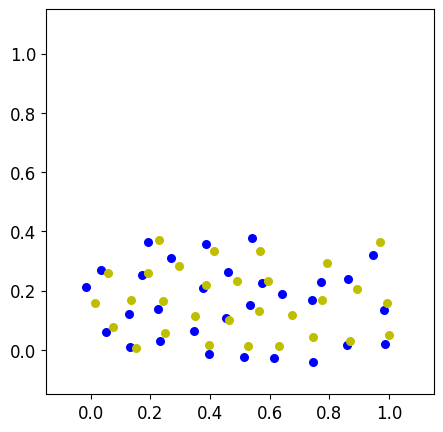

In [46]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ind = 20
ax.scatter(rec_test[ind,:,0]*l, rec_test[ind,:,1]*l, s=30, c="b")
ax.scatter(testset_conf[ind,:,0]*l, testset_conf[ind,:,1]*l, s=30, c="y")
ax.set_xlim(-0.15,1.15)
ax.set_ylim(-0.15,1.15)

MovieWriter imagemagick unavailable; using Pillow instead.


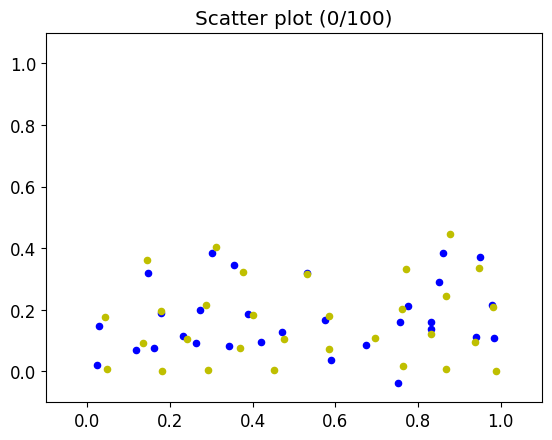

In [49]:
from matplotlib.animation import FuncAnimation

# Create the figure and axis objects
fig, ax = plt.subplots()

nframes = 100

# Define the animation function
def update(ind):
    ax.clear()
    plt.scatter(rec_test[ind,:,0]*l, rec_test[ind,:,1]*l, s=20, c="b")
    plt.scatter(testset_conf[ind,:,0]*l, testset_conf[ind,:,1]*l, s=20, c="y")
    ax.set_title(f"Scatter plot ({ind}/{nframes})")
    ax.set_xlim(-0.1,1.1)
    ax.set_ylim(-0.1,1.1)

# Create the animation
animation = FuncAnimation(fig, update, frames=nframes, interval=400)

# Save the animation as a GIF
animation.save("conv2dist.gif", writer="imagemagick")

## Deez Labels

In [50]:
labels = [1]*len(data)

In [54]:
def label_vis(vae, data, labels):
    
    #prediction
    z_mean, _, _ = vae.encoder.predict(data)
    
    #PCA on z_mean
    A = pd.DataFrame(z_mean)
    l, V = la.eig(np.cov(A.T))
    lr = np.copy(l.real)
    n1 = np.argmax(l)
    l[n1] = 0
    n2 = np.argmax(l)
    print(lr[n1]/sum(lr), lr[n2]/sum(lr), (lr[n1]+lr[n2])/sum(lr) )

    #plot
    plt.figure(figsize=(8, 8))
    plt.scatter(z_mean[:, n1], z_mean[:, n2], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

313/313 [==============================] - 6s 19ms/step
0.6851657463011186 0.31483425369888146 1.0


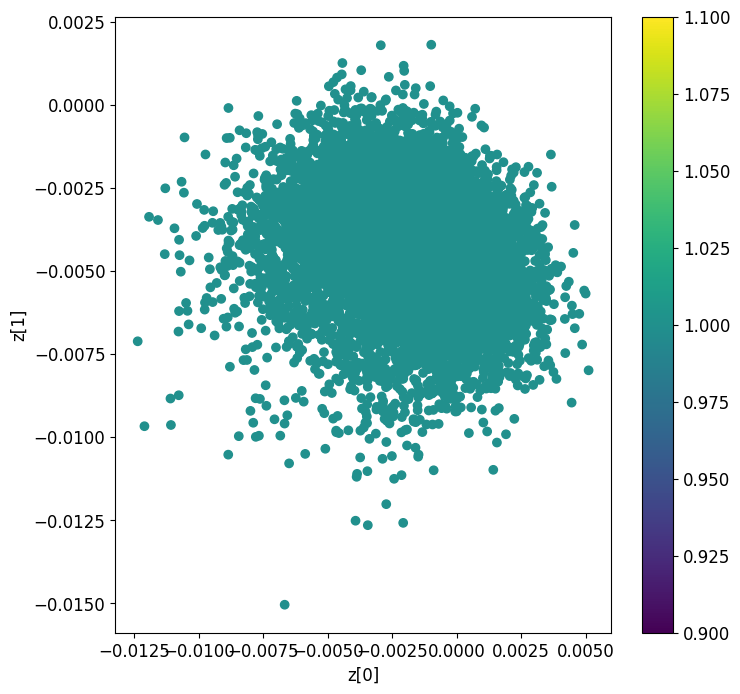

In [55]:
label_vis(vae, dm, labels)